In [1]:
import torch
import torchvision 
from torchvision import transforms, models, datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict
from PIL import Image
import seaborn as ss

In [2]:
from tqdm.notebook import tqdm

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_dir = {
    "train" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/",
    "valid": "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/validation/",
    "test" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/"
}

In [5]:
batch_size = 64

data_transforms = {
    
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop((224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation((-30,30)),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
        
    ]),
    
    'valid' : transforms.Compose([
        transforms.Resize((224,224)),
#         transforms.CenterCrop((254,254)),
        transforms.ToTensor(),
        transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
    ])
    
    
}

In [6]:
# data_set={
#         'train': torchvision.datasets.ImageFolder(data_dir['train'] ,data_transforms['train']),
#         'valid': torchvision.datasets.ImageFolder(data_dir['valid'], data_transforms['train']),
#          }

data_set={
        'train': torchvision.datasets.ImageFolder(data_dir['train'] ,data_transforms['train']),
        'valid': torchvision.datasets.ImageFolder(data_dir['valid'], data_transforms['valid']),
         }

In [7]:
for x,y in data_set['valid']:
    print(x.shape)
    print(y)
    break

torch.Size([3, 224, 224])
0


In [8]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(data_set['train'].targets), data_set['train'].targets) 
print(class_weights)
sample_weights = [0]*len(data_set['train'])
for idx, (data,label) in tqdm(enumerate(data_set['train'])):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight
from torch.utils.data import WeightedRandomSampler
sampler = sampler = WeightedRandomSampler(sample_weights, num_samples = len(sample_weights), replacement = True)

[0.91613101 0.83708572 1.4008893 ]


0it [00:00, ?it/s]

In [9]:
data_loader={
        'train': torch.utils.data.DataLoader(data_set['train'], batch_size=64,shuffle=False, sampler = sampler),
        'valid': torch.utils.data.DataLoader(data_set['valid'], batch_size=32,shuffle=False),
        }
# data_loader={
#         'train': torch.utils.data.DataLoader(data_set['train'], batch_size=64,shuffle=False),
#         'valid': torch.utils.data.DataLoader(data_set['valid'], batch_size=32,shuffle=False),
#         }

In [10]:
_ = data_set['valid'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}


In [11]:
cat_to_name

{0: 'covid', 1: 'normal', 2: 'pneumonia'}

In [12]:
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = True


In [13]:
model.classifier = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(1024,256)),
    ('dp1', nn.Dropout(0.3)),
    ('r1', nn.ReLU()),
    ('fcl2', nn.Linear(256,32)),
    ('dp2', nn.Dropout(0.3)),
    ('r2', nn.ReLU()),
    ('fcl3', nn.Linear(32,3)),
    ('out', nn.LogSoftmax(dim=1)),
]))


In [14]:
from tqdm.notebook import tqdm

In [15]:
def accuracy(y_pred,y_true):
    y_pred = torch.exp(y_pred)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [16]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5)
epochs = 35
valid_loss_min = np.Inf

In [17]:
device = 'cuda'

In [18]:
model = model.cuda()

In [19]:
train_loss_hist = []
valid_loss_hist = []
train_acc_hist = []
valid_acc_hist = []
valid_acc_min = 0

for i in range(epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 
    
    
    model.train()
    
    for images,labels in tqdm(data_loader['train']):
        
        images = images.to(device)
        labels = labels.to(device)
        
        ps = model(images)
        loss = criterion(ps,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += accuracy(ps,labels)
        train_loss += loss.item()
        
    avg_train_acc = train_acc / len(data_loader['train'])
    train_acc_hist.append(avg_train_acc)
    avg_train_loss = train_loss / len(data_loader['train'])
    train_loss_hist.append(avg_train_loss)
        
    model.eval()
    with torch.no_grad():
        
        for images,labels in tqdm(data_loader['valid']):
            
            images = images.to(device)
            labels = labels.to(device)
            
            ps = model(images)
            loss = criterion(ps,labels)
            
            valid_acc += accuracy(ps,labels)
            valid_loss += loss.item()
            
            
        avg_valid_acc = valid_acc / len(data_loader['valid'])
        valid_acc_hist.append(avg_valid_acc)
        avg_valid_loss = valid_loss / len(data_loader['valid'])
        valid_loss_hist.append(avg_valid_loss)
        
        schedular.step(avg_valid_loss)
        
        if avg_valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'DenseNet_size224.pt')
            
            valid_loss_min = avg_valid_loss
            
        if avg_valid_acc >= valid_acc_min:
            print('Validation Accuracy increase ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_acc_min,avg_valid_acc))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'DenseNet_size_224_best_acc.pt')
            
            valid_acc_min = avg_valid_acc
            
            
    print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1,avg_train_loss,avg_train_acc))
    print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1,avg_valid_loss,avg_valid_acc))


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.582739).   Saving model ...
Validation Accuracy increase (0.000000 --> 0.796007).   Saving model ...
Epoch : 1 Train Loss : 0.545746 Train Acc : 0.786658
Epoch : 1 Valid Loss : 0.582739 Valid Acc : 0.796007


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.582739 --> 0.458203).   Saving model ...
Validation Accuracy increase (0.796007 --> 0.818576).   Saving model ...
Epoch : 2 Train Loss : 0.388408 Train Acc : 0.860721
Epoch : 2 Valid Loss : 0.458203 Valid Acc : 0.818576


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.338294 Train Acc : 0.876346
Epoch : 3 Valid Loss : 0.703664 Valid Acc : 0.791377


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.458203 --> 0.312971).   Saving model ...
Validation Accuracy increase (0.818576 --> 0.888021).   Saving model ...
Epoch : 4 Train Loss : 0.299224 Train Acc : 0.894052
Epoch : 4 Valid Loss : 0.312971 Valid Acc : 0.888021


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.276550 Train Acc : 0.904260
Epoch : 5 Valid Loss : 0.584126 Valid Acc : 0.809606


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.265460 Train Acc : 0.906709
Epoch : 6 Valid Loss : 0.351789 Valid Acc : 0.880498


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.247433 Train Acc : 0.913271
Epoch : 7 Valid Loss : 0.597312 Valid Acc : 0.838831


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.312971 --> 0.310012).   Saving model ...
Validation Accuracy increase (0.888021 --> 0.899016).   Saving model ...
Epoch : 8 Train Loss : 0.243674 Train Acc : 0.916513
Epoch : 8 Valid Loss : 0.310012 Valid Acc : 0.899016


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation Accuracy increase (0.899016 --> 0.899306).   Saving model ...
Epoch : 9 Train Loss : 0.237312 Train Acc : 0.914494
Epoch : 9 Valid Loss : 0.323606 Valid Acc : 0.899306


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.310012 --> 0.280786).   Saving model ...
Epoch : 10 Train Loss : 0.229964 Train Acc : 0.918442
Epoch : 10 Valid Loss : 0.280786 Valid Acc : 0.898438


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.219703 Train Acc : 0.923353
Epoch : 11 Valid Loss : 0.337301 Valid Acc : 0.895833


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.206315 Train Acc : 0.927675
Epoch : 12 Valid Loss : 0.379358 Valid Acc : 0.889757


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.210531 Train Acc : 0.925914
Epoch : 13 Valid Loss : 0.382789 Valid Acc : 0.878762


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.197641 Train Acc : 0.930567
Epoch : 14 Valid Loss : 0.339742 Valid Acc : 0.896991


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.203998 Train Acc : 0.926543
Epoch : 15 Valid Loss : 0.388861 Valid Acc : 0.875289


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.280786 --> 0.257368).   Saving model ...
Validation Accuracy increase (0.899306 --> 0.913484).   Saving model ...
Epoch : 16 Train Loss : 0.184804 Train Acc : 0.936089
Epoch : 16 Valid Loss : 0.257368 Valid Acc : 0.913484


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.191329 Train Acc : 0.936066
Epoch : 17 Valid Loss : 0.309329 Valid Acc : 0.899884


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.257368 --> 0.229855).   Saving model ...
Validation Accuracy increase (0.913484 --> 0.919560).   Saving model ...
Epoch : 18 Train Loss : 0.175263 Train Acc : 0.939297
Epoch : 18 Valid Loss : 0.229855 Valid Acc : 0.919560


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.179043 Train Acc : 0.939162
Epoch : 19 Valid Loss : 0.261407 Valid Acc : 0.909722


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.229855 --> 0.216347).   Saving model ...
Validation Accuracy increase (0.919560 --> 0.933738).   Saving model ...
Epoch : 20 Train Loss : 0.176535 Train Acc : 0.940239
Epoch : 20 Valid Loss : 0.216347 Valid Acc : 0.933738


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 21 Train Loss : 0.167867 Train Acc : 0.941910
Epoch : 21 Valid Loss : 0.343167 Valid Acc : 0.897569


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 22 Train Loss : 0.165502 Train Acc : 0.942300
Epoch : 22 Valid Loss : 0.252983 Valid Acc : 0.916667


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 23 Train Loss : 0.159960 Train Acc : 0.945747
Epoch : 23 Valid Loss : 0.316747 Valid Acc : 0.906829


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 24 Train Loss : 0.160998 Train Acc : 0.944986
Epoch : 24 Valid Loss : 0.247470 Valid Acc : 0.918981


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 25 Train Loss : 0.146027 Train Acc : 0.948990
Epoch : 25 Valid Loss : 0.370528 Valid Acc : 0.899884


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 26 Train Loss : 0.152938 Train Acc : 0.947878
Epoch : 26 Valid Loss : 0.449812 Valid Acc : 0.873553


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.216347 --> 0.204598).   Saving model ...
Validation Accuracy increase (0.933738 --> 0.936343).   Saving model ...
Epoch : 27 Train Loss : 0.112670 Train Acc : 0.961390
Epoch : 27 Valid Loss : 0.204598 Valid Acc : 0.936343


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation Accuracy increase (0.936343 --> 0.937500).   Saving model ...
Epoch : 28 Train Loss : 0.088572 Train Acc : 0.969268
Epoch : 28 Valid Loss : 0.209187 Valid Acc : 0.937500


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation Accuracy increase (0.937500 --> 0.938947).   Saving model ...
Epoch : 29 Train Loss : 0.088391 Train Acc : 0.969359
Epoch : 29 Valid Loss : 0.212013 Valid Acc : 0.938947


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation Accuracy increase (0.938947 --> 0.942130).   Saving model ...
Epoch : 30 Train Loss : 0.079854 Train Acc : 0.971603
Epoch : 30 Valid Loss : 0.205564 Valid Acc : 0.942130


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 31 Train Loss : 0.077906 Train Acc : 0.974012
Epoch : 31 Valid Loss : 0.235998 Valid Acc : 0.936343


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 32 Train Loss : 0.076056 Train Acc : 0.974773
Epoch : 32 Valid Loss : 0.221147 Valid Acc : 0.938657


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.204598 --> 0.203434).   Saving model ...
Validation Accuracy increase (0.942130 --> 0.942130).   Saving model ...
Epoch : 33 Train Loss : 0.080369 Train Acc : 0.973233
Epoch : 33 Valid Loss : 0.203434 Valid Acc : 0.942130


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 34 Train Loss : 0.074490 Train Acc : 0.974790
Epoch : 34 Valid Loss : 0.213102 Valid Acc : 0.940394


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 35 Train Loss : 0.064978 Train Acc : 0.977202
Epoch : 35 Valid Loss : 0.224338 Valid Acc : 0.940972


In [1]:
!nvidia-smi

Wed Oct  6 06:06:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GT 710      Off  | 00000000:01:00.0 N/A |                  N/A |
| 40%   53C    P8    N/A /  N/A |    191MiB /  2000MiB |     N/A      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   

Text(0, 0.5, 'Accuracy')

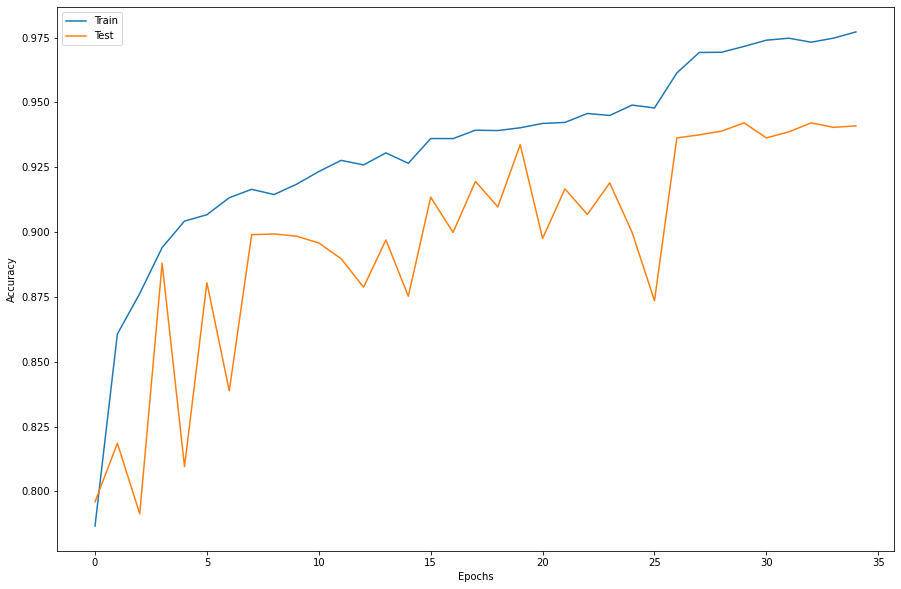

In [20]:
plt.figure(figsize=(15,10))
plt.plot(train_acc_hist, label = 'Train')
plt.plot(valid_acc_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

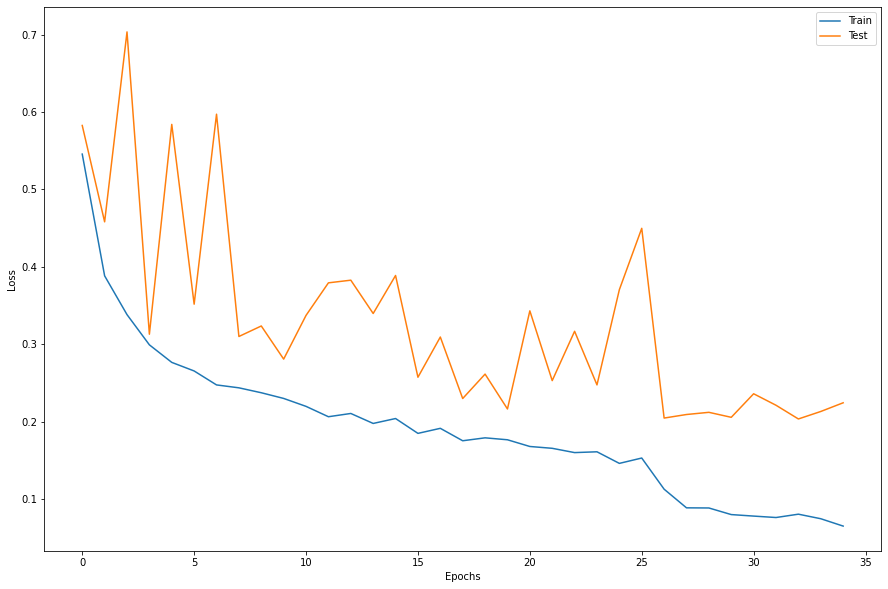

In [21]:
plt.figure(figsize=(15,10))
plt.plot(train_loss_hist, label = 'Train')
plt.plot(valid_loss_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [18]:
model = model.cpu()

In [19]:
device = 'cpu'

In [29]:
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [45]:
nb_classes = 3
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in tqdm(enumerate(data_loader['valid'])):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes, preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

0it [00:00, ?it/s]

In [46]:
import pandas as pd
import seaborn as sns

In [ ]:
plt.figure(figsize=(15,10))

class_names = data_loader['valid'].dataset.classes
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("/media/brats/DRIVE1/akansh/DeepXrays/Figures/Densenet_35_224.jpg")

### Evaluation

In [41]:
path2weights="/media/brats/DRIVE1/akansh/DeepXrays/Notebooks/Chest-XR-Grand_challenge/DenseNet_size_224_best_acc.pt"
model.load_state_dict(torch.load(path2weights)['model_state_dict'])
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [42]:
import pandas as pd
import os
from torch.utils.data import Dataset
from PIL import Image
import time

class covid_dataset(Dataset):
    def __init__(self, image_loc, label_loc, transform):
        filenames = os.listdir(image_loc)
        self.full_filenames = [os.path.join(image_loc,f) for f in filenames]
        label_df = pd.read_csv(label_loc)
        label_df.set_index("case", inplace = True)
        
        self.labels = [label_df.loc[filename].values[0] for filename in filenames]
        
        self.transform = transform
        
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self,idx):
        image = Image.open(self.full_filenames[idx])
        image = image.convert('RGB')
        image = self.transform(image)
        return image, self.labels[idx]

test_data = covid_dataset(image_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/",
                         label_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/submission.csv",
                         transform = data_transforms['valid'])

def deploy_model(model, dataset, device, num_classes = 3, sanity_check = False):
    len_data = len(dataset)
    y_out=torch.zeros(len_data,num_classes)
    y_gt=np.zeros((len_data),dtype="uint8")
    model=model.to(device)
    elapsed_times=[]
    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y = dataset[i]
#             y_gt[i] = y
            start=time.time()
            y_out[i]=F.softmax(model(x.unsqueeze(0).to(device)),dim = 1)
            elapsed=time.time()-start
            elapsed_times.append(elapsed)
            if sanity_check is True:
                break
            inference_time=np.mean(elapsed_times)*1000
    print("average inference time per image on %s: %.2f ms "%(device,inference_time))
    return y_out.numpy(),y_gt
        

In [43]:
from torch.nn import functional as F

In [44]:
y_test_out,_=deploy_model(model,test_data, device,sanity_check=False)
y_test_pred=np.argmax(y_test_out,axis=1)
print(y_test_pred)
print(np.unique(y_test_pred, return_counts=True))

  0%|          | 0/1200 [00:00<?, ?it/s]

average inference time per image on cuda: 34.91 ms 
[2 2 1 ... 2 1 2]
(array([0, 1, 2]), array([388, 443, 369]))


In [25]:
y_test_out

array([[0.02799794, 0.07404657, 0.8979554 ],
       [0.00380171, 0.08287122, 0.9133271 ],
       [0.08706542, 0.06893237, 0.8440022 ],
       ...,
       [0.01344011, 0.06542713, 0.9211328 ],
       [0.00246139, 0.20983085, 0.78770787],
       [0.01291368, 0.05224258, 0.9348437 ]], dtype=float32)

In [28]:
y_test_pred=np.argmax(y_test_out,axis=1)

In [30]:
np.unique(y_test_pred, return_counts=True)

(array([0, 1, 2]), array([398, 433, 369]))

In [31]:
y_test_pred[10]

0

In [100]:
test_csv[' class'] = y_test_pred

In [103]:
test_csv.to_csv('first_sub_akansh.csv', index = False)